In [17]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


torch.manual_seed(1)

# Clean data

In [39]:
df = pd.read_csv('../data_NO2.csv', sep=';') # 
df['datetime_utc'] = pd.to_datetime(df['datetime_utc']) # datetime_utc
df['ret'] = (df['spot_price']-df['spot_price'].shift(1))/df['spot_price'].shift(1)
df = df[~df['ret'].isna()].copy()


df_weather = pd.read_csv('../data_NO2_boosted.csv')
df_weather.rename({'date': 'datetime_utc'}, axis=1, inplace=True)
df_weather['datetime_utc'] = pd.to_datetime(df_weather['datetime_utc'], utc=True)

df = pd.merge(df, df_weather[['datetime_utc', 'krs_temp_2m', 'stv_temp_2m', 'gas_price']], how='left', on='datetime_utc')
df.sort_values('datetime_utc', inplace=True)

df['date'] = df['datetime_utc'].dt.date
n_obs = df.groupby('date')['ret'].count()
odd_dates = n_obs[n_obs != 24].index
df.drop('date', axis=1, inplace=True)
# display(df[df['datetime_utc'].dt.date.isin(odd_dates)])


if len(odd_dates) > 0:
    df = df[df['datetime_utc'] < pd.to_datetime('2018-09-13 00:00:00+00:00')].copy()
    df.loc[len(df)+1, :] = [pd.to_datetime('2016-10-30 00:00:00+00:00'), 3450.5, 3027.0, 32.025, -0.003888, 7.1, 8.7, 2.72]
    df.loc[len(df)+1, :] = [pd.to_datetime('2017-10-29 00:00:00+00:00'), 3584.5, 3890.0, 22.325, -0.074036, 7.6, 7.9, 2.78]
df.sort_values(by='datetime_utc', inplace=True)
# df['pred_ret'] = df['ret'].shift(24)
# display(df)
# df = df.dropna(axis=0)
df.reset_index(inplace=True, drop=True)
df


,datetime_utc,volume_demand,volume_production,spot_price,ret,krs_temp_2m,stv_temp_2m,gas_price
0,2016-01-01 00:00:00+00:00,4010.0,7694.0,16.04,-0.021354,6.1,6.9,2.28
1,2016-01-01 01:00:00+00:00,3930.0,7437.0,15.74,-0.018703,6.3,7.0,2.28
2,2016-01-01 02:00:00+00:00,3839.0,7120.0,15.57,-0.010801,6.5,7.4,2.28
3,2016-01-01 03:00:00+00:00,3833.0,7041.0,15.47,-0.006423,6.7,8.0,2.28
4,2016-01-01 04:00:00+00:00,3944.0,7246.0,15.75,0.018100,6.8,7.8,2.28
...,...,...,...,...,...,...,...,...
23659,2018-09-12 19:00:00+00:00,3848.0,6170.0,54.26,-0.011297,11.3,11.7,2.94
23660,2018-09-12 20:00:00+00:00,3706.0,5552.0,52.06,-0.040546,11.0,11.5,2.94
23661,2018-09-12 21:00:00+00:00,3534.0,5297.0,49.55,-0.048214,10.7,10.9,2.94
23662,2018-09-12 22:00:00+00:00,3399.0,4843.0,50.53,0.019778,10.3,10.7,2.94


In [40]:
df.isna().any()

datetime_utc         False
volume_demand        False
volume_production    False
spot_price           False
ret                  False
krs_temp_2m          False
stv_temp_2m          False
gas_price            False
dtype: bool

In [38]:
class PriceForecastingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PriceForecastingLSTM, self).__init__()
        self.layer_dim = num_layers
        self.hidden_dim = hidden_size
        self.lstm_layer = nn.LSTM(input_size=input_size, 
                                  hidden_size=hidden_size, 
                                  num_layers=num_layers, 
                                  batch_first=True,
                                  bidirectional=False)
        self.fc_layer = nn.Linear(hidden_size, output_size)  # Output size = 24

    def forward(self, x):
        out, (hn, cn) = self.lstm_layer(x)
        out = self.fc_layer(out)  # Selecting the last output
        return out[:,-1,:]

In [52]:
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(df[['spot_price', 'volume_demand', 'volume_production', 'krs_temp_2m', 'stv_temp_2m', 'gas_price']])

def create_sequences(data, input_seq_len=24, output_seq_len=24):
    X, y = [], []
    for i in range(0, len(data) - input_seq_len - output_seq_len, 24):
        X.append(data[i:i+input_seq_len])
        y.append(data[i+input_seq_len:i+input_seq_len+output_seq_len, 0])  # Only price for output
    return np.array(X), np.array(y)

X, y = create_sequences(data_normalized)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

train_perc = 0.8
cutoff = int(len(X)*train_perc)

X_train, X_test = X[0:cutoff], X[cutoff:]
y_train, y_test = y[0:cutoff], y[cutoff:]

# Hyperparameters
input_size = 6         # Number of features (price, demand, production)
hidden_size = 64       # Number of hidden units in LSTM
num_layers = 3         # Number of LSTM layers
output_size = 24      # Forecasting 24 hours of price

model = PriceForecastingLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [10/1000], Loss: 0.0218
Epoch [20/1000], Loss: 0.0034
Epoch [30/1000], Loss: 0.0037
Epoch [40/1000], Loss: 0.0030
Epoch [50/1000], Loss: 0.0029
Epoch [60/1000], Loss: 0.0026
Epoch [70/1000], Loss: 0.0024
Epoch [80/1000], Loss: 0.0023
Epoch [90/1000], Loss: 0.0021
Epoch [100/1000], Loss: 0.0019
Epoch [110/1000], Loss: 0.0016
Epoch [120/1000], Loss: 0.0015
Epoch [130/1000], Loss: 0.0013
Epoch [140/1000], Loss: 0.0012
Epoch [150/1000], Loss: 0.0011
Epoch [160/1000], Loss: 0.0010
Epoch [170/1000], Loss: 0.0010
Epoch [180/1000], Loss: 0.0010
Epoch [190/1000], Loss: 0.0009
Epoch [200/1000], Loss: 0.0009
Epoch [210/1000], Loss: 0.0009
Epoch [220/1000], Loss: 0.0009
Epoch [230/1000], Loss: 0.0009
Epoch [240/1000], Loss: 0.0009
Epoch [250/1000], Loss: 0.0009
Epoch [260/1000], Loss: 0.0009
Epoch [270/1000], Loss: 0.0008
Epoch [280/1000], Loss: 0.0008
Epoch [290/1000], Loss: 0.0008
Epoch [300/1000], Loss: 0.0008
Epoch [310/1000], Loss: 0.0008
Epoch [320/1000], Loss: 0.0008
Epoch [330/1000],

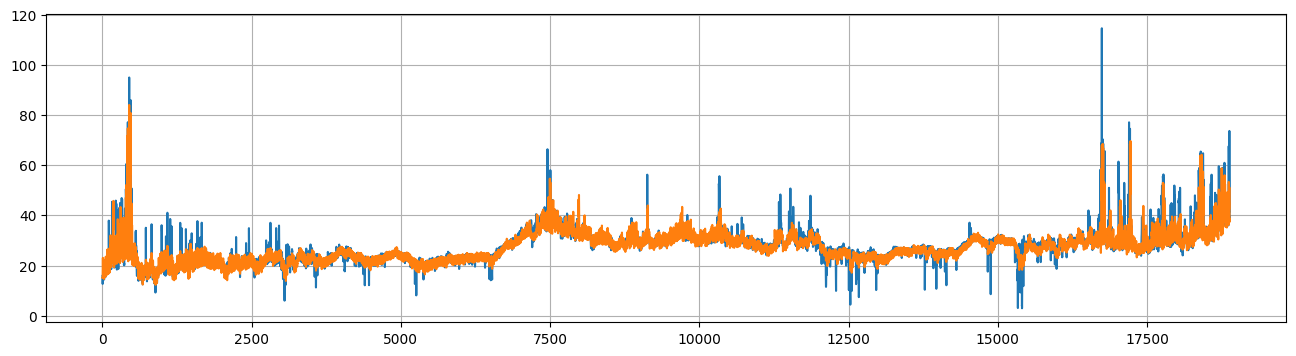

Training set:
18888
MSE: 6.42209
RMSE: 2.53418

Test set:
4728
MSE: 103.48513
RMSE: 10.17276


In [53]:
model.eval()
with torch.no_grad():
    predictions = model(X_train)

pred_array = predictions.reshape(-1)
true_array = y_train.reshape(-1)



# # Inverse transform each 24-hour prediction set separately
pred_orig_scale = scaler.inverse_transform(
    np.concatenate([[pred_array], np.zeros((5, pred_array.shape[0]))], axis=0).T
)[:, 0]  # Get only the price column

true_orig_scale = scaler.inverse_transform(
    np.concatenate([[true_array], np.zeros((5, true_array.shape[0]))], axis=0).T
)[:, 0]

price_df_train = df['spot_price'].iloc[24:24+len(true_orig_scale)]

plt.figure(figsize=(16,4))

n = len(price_df_train)
a = true_orig_scale[:n]
b = pred_orig_scale[:n]

plt.plot([i for i in range(len(a))], a)
plt.plot([i for i in range(len(b))], b)
plt.grid()
plt.show()


def eval(y_true, y_pred):
    print(len(y_true))
    MSE = ((y_true-y_pred)**2).mean()
    print(f"MSE: {round(MSE, 5)}")
    RMSE = MSE**(1/2)
    print(f"RMSE: {round(RMSE, 5)}")
print('Training set:')
eval(true_orig_scale, pred_orig_scale)

model.eval()
with torch.no_grad():
    predictions = model(X_test)
pred_array = predictions.reshape(-1)
true_array = y_test.reshape(-1)

pred_orig_scale = scaler.inverse_transform(
    np.concatenate([[pred_array], np.zeros((5, pred_array.shape[0]))], axis=0).T
)[:, 0]
true_orig_scale = scaler.inverse_transform(
    np.concatenate([[true_array], np.zeros((5, true_array.shape[0]))], axis=0).T
)[:, 0]
print('\nTest set:')
eval(true_orig_scale, pred_orig_scale)

In [54]:
5*6*7

210